# Reward design and testing

In [2]:
# Import relevant libraries

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')

from flatland.envs.line_generators import SparseLineGen
from flatland.envs.malfunction_generators import (
    MalfunctionParameters,
    ParamMalfunctionGen,
)
from flatland.envs.rail_generators import SparseRailGen
from flatland.envs.observations import TreeObsForRailEnv

import numpy as np
import matplotlib.pyplot as plt
from src import test_utils, training, rewards
from src.observation_utils import normalize_observation
from src.models import *
from src.deep_model_policy import DeepPolicy, PolicyParameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reward design

In [2]:
# Must modify two functions in env
#env.update_step_rewards
#env._handle_end_reward

Ideas :

- Dense reward from https://arxiv.org/pdf/2103.16511.pdf : -1 while not reaching, 0 if reached +1 if all trains reached
- Dense reward, ex : -1 while not reaching target or reward proportional to distance to target, but needs malus for collisions
- Sparse reward with bonus if all trains reach target
- Sparse reward with bonus if all trains reach target and malus for collisions
- Reward that evolves with training

Dense reward with bonus depart/arrival and malus for deadlocks : https://arxiv.org/pdf/2210.12933.pdf

Agents are given rewards at every time step, according to their performance within the moment. Besides the normalized reward generated by the environment, agents are also rewarded when they depart from stations, arrive at targets, and get penalized when deadlocks happen. To promote co-operation between them, these rewards are shared by all agents, and no credit assignment is performed. As a result, a single agent is encouraged to wait for others if the waiting can lead to global efficiency improvement.

In [4]:
test_envs = rewards.get_testing_environements(
    width=20,
    height=15,
    rail_generator=SparseRailGen(
        max_num_cities=2,  # Number of cities
        grid_mode=True,
        max_rails_between_cities=2,
        max_rail_pairs_in_city=1,
    ),
    line_generator=SparseLineGen(speed_ratio_map={1.: 1.}
        ),
    number_of_agents=2, 
    obs_builder_object=TreeObsForRailEnv(max_depth=3),
    malfunction_generator=ParamMalfunctionGen(
        MalfunctionParameters(
            malfunction_rate=0.,  # Rate of malfunction
            min_duration=3,  # Minimal duration
            max_duration=20,  # Max duration
        )
    )
)

## Testing

In [38]:
# Train this environment

key = "JBR"

env = test_envs[key]

policy_params = PolicyParameters(action_size=5, buffer_size=int(1e5), 
                                 batch_size=32, gamma=0.99, tau=1e-3, 
                                 lr=5e-4, update_every=4, use_gpu=True)
observation_tree_depth = 3
observation_radius = 10
observation_max_path_depth = 20

n_features_per_node = env.obs_builder.observation_dim
n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
state_size = n_features_per_node * n_nodes

model = DuelingQNetwork(state_size, policy_params.action_size)
policy = DeepPolicy(model, policy_params)

In [39]:
# Train the policy
obs_params = {
    "observation_tree_depth": observation_tree_depth,
    "observation_radius": observation_radius,
}
train_params = {
    "eps_start": 1.0,
    "eps_end": 0.01,
    "eps_decay": 0.995,
    "n_episodes": 1200,
    "checkpoint_interval": 50,
    "n_eval_episodes": 1,
    "restore_replay_buffer": False,
    "save_replay_buffer": False,
    "render": False,
    "buffer_size": int(1e5),
}

In [40]:
training.train_agent(env, policy, train_params, obs_params, checkpoints_folder='pauline/'+key+'/')


💾 Replay buffer status: 0/100000 experiences

🚉 Training 2 trains on 20x15 grid for 1200 episodes, evaluating on 1 episodes every 50 episodes.

🚂 Episode 0	 🏆 Score: -4.076 Avg: -1.031	 💯 Done: 0.00% Avg: 0.00%	 🎲 Epsilon: 0.995 	 🔀 Action Probs: ↻ 0.167 ← 0.167 ↑ 0.167 → 0.256 ◼ 0.244  	✅ Eval: score -4.706 done 0.0%
	🔍 Evaluation score: -4.706 done: 0.0%
🚂 Episode 50	 🏆 Score: -4.500 Avg: -2.301	 💯 Done: 0.00% Avg: 4.36%	 🎲 Epsilon: 0.774 	 🔀 Action Probs: ↻ 0.184 ← 0.105 ↑ 0.289 → 0.211 ◼ 0.211  	✅ Eval: score -1.970 done 100.0%
	🔍 Evaluation score: -1.970 done: 100.0%
🚂 Episode 100	 🏆 Score: -4.255 Avg: -2.928	 💯 Done: 50.00% Avg: 10.16%	 🎲 Epsilon: 0.603 	 🔀 Action Probs: ↻ 0.222 ← 0.233 ↑ 0.233 → 0.156 ◼ 0.156  	✅ Eval: score -4.402 done 0.0%
	🔍 Evaluation score: -4.402 done: 0.0%
🚂 Episode 150	 🏆 Score: -3.676 Avg: -3.295	 💯 Done: 50.00% Avg: 14.04%	 🎲 Epsilon: 0.469 	 🔀 Action Probs: ↻ 0.111 ← 0.127 ↑ 0.397 → 0.079 ◼ 0.286  	✅ Eval: score 0.000 done 0.0%
	🔍 Evaluation score: 0

In [86]:
policy.load('Pauline/JBR/checkpoint_1150.pth')

In [87]:
# Test the policy
n_test = 100

scores, completions, nb_steps, seeds = test_utils.test_policy(env, policy, n_test, obs_params)

	✅ Eval: score -0.227 done 57.5%


In [92]:
# Get argmin of scores
worst_seed = seeds[np.argmin(scores)]
best_seed = seeds[np.argmax(scores)]

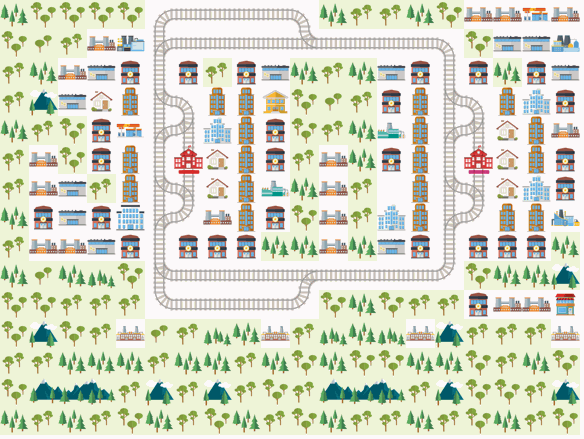

In [103]:
# Test the policy on the worst seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=worst_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

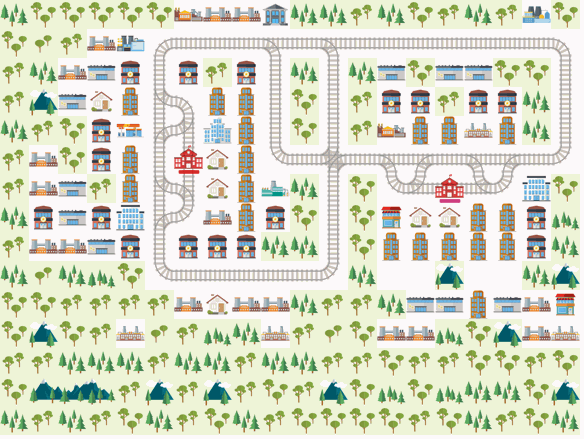

In [102]:
# Test the policy on the best seed
env_renderer = test_utils.render_one_test(env, policy, obs_params, seed=best_seed, real_time_render=False, force_gif=True)
env_renderer.make_gif('test')

# Example Render - toy test

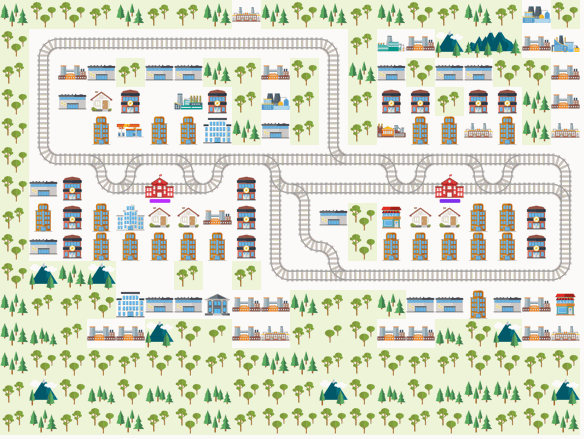

In [3]:
# Step loop with video rendering, shortest path policy

obs, info = env.reset(random_seed=10)
env_renderer = test_utils.RenderWrapper(env, real_time_render=False, force_gif=True)
env_renderer.render()

while True:
    actions = {}
    for handle in env.get_agent_handles():
        actions[handle] = 2
    obs, all_rewards, done, _ = env.step(actions)
    env_renderer.render()
    if done['__all__']:
        break

env_renderer.make_gif('test.gif')